In [1]:
import scanpy as sc
import transcriptomic_clustering as tc 

In [2]:
tasic_adata = sc.read_h5ad('./data/tasic2016counts_sparse.h5ad')

# Normalize
normalized_adata = tc.normalize(tasic_adata)


In [3]:
normalized_adata

AnnData object with n_obs × n_vars = 1809 × 24057

In [4]:
tasic_adata = sc.read_h5ad('./data/tasic2016counts_sparse.h5ad')

# Normalize
normalized_adata = tc.normalize(tasic_adata)

# Highly Variant Genes
means, variances, gene_mask = tc.get_means_vars_genes(adata=normalized_adata)
tc.highly_variable_genes(adata=normalized_adata, 
                         means=means, variances=variances, 
                         gene_mask=gene_mask, max_genes=3000)

# PCA
(components, explained_variance_ratio, explained_variance, means) = \
    tc.pca(normalized_adata, n_comps=25, cell_select=1000, use_highly_variable=True, svd_solver='arpack')
print(components)

                     0         1         2         3         4         5   \
0610007N19Rik -0.002378  0.004150  0.001200  0.001587 -0.000753  0.011344   
0610039K10Rik -0.000095  0.000565  0.002082  0.001958 -0.001451 -0.000860   
0610040J01Rik  0.000197  0.005470 -0.000802  0.000964  0.001247  0.002955   
1110006O24Rik -0.000565  0.001519 -0.000887 -0.000975 -0.000732  0.000464   
1110015O18Rik -0.000788  0.002105 -0.001119 -0.000146  0.001941  0.000082   
...                 ...       ...       ...       ...       ...       ...   
mt_AK159262   -0.009143  0.005321  0.021414 -0.036784  0.012807  0.013110   
mt_AK166684    0.000671  0.007357  0.000658  0.001428  0.007226  0.017149   
mt_BC006023    0.007920  0.003425 -0.011109  0.003415 -0.005461 -0.008792   
mt_BC104337   -0.001113  0.007091  0.004068 -0.001704  0.002782  0.007990   
mt_GU332589   -0.013548  0.012949  0.011614 -0.008736 -0.005927  0.016569   

                     6         7         8         9   ...        15  \
061

## Filter Known Modes

In [5]:
known_modes = components[[24]] # select last component as a known mode as an example
print(known_modes)

                     24
0610007N19Rik  0.004506
0610039K10Rik  0.004104
0610040J01Rik -0.007712
1110006O24Rik -0.001591
1110015O18Rik  0.000692
...                 ...
mt_AK159262   -0.026740
mt_AK166684    0.024220
mt_BC006023   -0.002310
mt_BC104337    0.011588
mt_GU332589   -0.011688

[3000 rows x 1 columns]


In [6]:
components = tc.filter_known_modes(components, known_modes)
print(components.shape)

(3000, 24)


## Projection

In [7]:
projected_adata = tc.project(normalized_adata, components, means)
projected_adata

/home/sergeyg/repos/anndata/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1809 × 24

## Louvain Clustering

In [8]:
cluster_by_obs, obs_by_cluster, graph, qc = tc.cluster_louvain(projected_adata, 30, n_jobs=8)

100%|██████████| 1809/1809 [00:00<00:00, 17403.15it/s]


In [9]:
# REMOVE
import numpy as np
def get_cluster_means(adata, cluster_assignments):
    cluster_means = {}

    for label, idx in cluster_assignments.items():
        adata_view = adata[idx, :]
        X = adata_view.X
        cluster_means[label] = np.asarray(np.mean(X, axis=0)).ravel()

    return cluster_means

In [12]:
projected_adata

AnnData object with n_obs × n_vars = 1809 × 24

In [13]:
obs_by_cluster

{0: [0,
  23,
  36,
  37,
  42,
  58,
  59,
  332,
  431,
  438,
  439,
  442,
  444,
  447,
  449,
  451,
  463,
  464,
  473,
  941,
  1672,
  1675,
  1676,
  1677,
  1681,
  1687,
  1691,
  1725,
  1732,
  1733,
  1,
  14,
  33,
  54,
  55,
  56,
  403,
  410,
  420,
  422,
  440,
  453,
  459,
  462,
  465,
  466,
  1353,
  1671,
  1674,
  1679,
  1680,
  1728,
  1731,
  1737,
  3,
  12,
  28,
  34,
  48,
  62,
  64,
  65,
  66,
  67,
  68,
  70,
  331,
  401,
  428,
  434,
  437,
  454,
  489,
  578,
  636,
  645,
  1690,
  1692,
  1701,
  1712,
  1715,
  1717,
  1723,
  1724,
  4,
  355,
  377,
  397,
  411,
  460,
  509,
  519,
  1673,
  1698,
  1707,
  1708,
  1709,
  1710,
  1721,
  1730,
  1734,
  1736,
  16,
  20,
  336,
  340,
  380,
  416,
  435,
  474,
  485,
  1699,
  1711,
  1722,
  1727,
  18,
  25,
  51,
  69,
  338,
  404,
  417,
  579,
  1726,
  1738,
  15,
  35,
  40,
  43,
  63,
  350,
  362,
  371,
  455,
  456,
  471,
  478,
  535,
  1686,
  1696,
  1735,
  19,


## Merging

In [14]:
#Coming soonprint(f"finished reading data: {time_1-time_0}")
from transcriptomic_clustering import merging

cluster_assignments_before_merging =obs_by_cluster
cluster_sizes_before_merging = {k: len(v) for k, v in cluster_assignments_before_merging.items()}





In [15]:

cluster_assignments_after_merging = merging.merge_clusters(
    adata_norm=normalized_adata,
    adata_reduced=projected_adata,
    cluster_assignments=cluster_assignments_before_merging,
    cluster_by_obs=cluster_by_obs,
    min_cluster_size=6,
)


ValueError: too many values to unpack (expected 2)

## Hierarchical Sorting

In [9]:
cluster_means = get_cluster_means(projected_adata, obs_by_cluster)
linkage, labels = tc.hclust(cluster_means)

In [10]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
%matplotlib inline

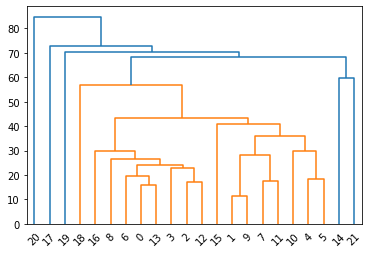

In [11]:
fig = plt.figure()
dendrogram(linkage, labels=labels)
plt.show()